<a href="https://colab.research.google.com/github/rezahamzeh69/Intrusion-Detection-LSTM/blob/main/LSTM_model_on_UNSW_NB15_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving UNSW_NB15_testing-set.csv to UNSW_NB15_testing-set.csv
Saving UNSW_NB15_training-set.csv to UNSW_NB15_training-set.csv
Uploaded files: ['UNSW_NB15_testing-set.csv', 'UNSW_NB15_training-set.csv']
Training DataFrame shape: (175341, 45)
Testing DataFrame shape: (82332, 45)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)        │ (None, 1, 128)              │         133,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 64)                  │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 174,913 (683.25 KB)

 Trainable params: 174,913 (683.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
2192/2192 ━━━━━━━━━━━━━━━━━━━━ 77s 29ms/step - accuracy: 0.9350 - loss: 0.1636 - val_accuracy: 0.9996 - val_loss: 0.0016 - learning_rate: 0.0010
Epoch 2/50
2192/2192 ━━━━━━━━━━━━━━━━━━━━ 80s 29ms/step - accuracy: 0.9886 - loss: 0.0289 - val_accuracy: 0.9996 - val_loss: 0.0014 - learning_rate: 0.0010
Epoch 3/50
2192/2192 ━━━━━━━━━━━━━━━━━━━━ 81s 29ms/step - accuracy: 0.9943 - loss: 0.0148 - val_accuracy: 0.9997 - val_loss: 0.0024 - learning_rate: 0.0010
Epoch 4/50
2192/2192 ━━━━━━━━━━━━━━━━━━━━ 64s 29ms/step - accuracy: 0.9963 - loss: 0.0101 - val_accuracy: 0.9899 - val_loss: 0.0223 - learning_rate: 0.0010
Epoch 5/50
2192/2192 ━━━━━━━━━━━━━━━━━━━━ 79s 28ms/step - accuracy: 0.9972 - loss: 0.0078 - val_accuracy: 0.9998 - val_loss: 0.0041 - learning_rate: 0.0010
Epoch 6/50
2192/2192 ━━━━━━━━━━━━━━━━━━━━ 62s 28ms/step - accuracy: 0.9977 - loss: 0.0070 - val_accuracy: 0.9770 - val_loss: 0.0664 - learning_rate: 5.0000e-04
Epoch 7/50
2192/2192 ━━━━━━━━━━━━━━━━━━━━ 83s 29ms/step - ac

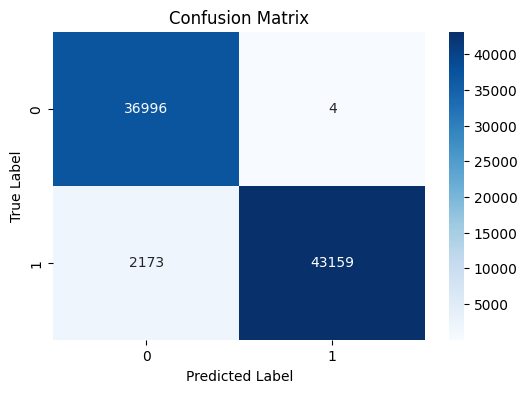

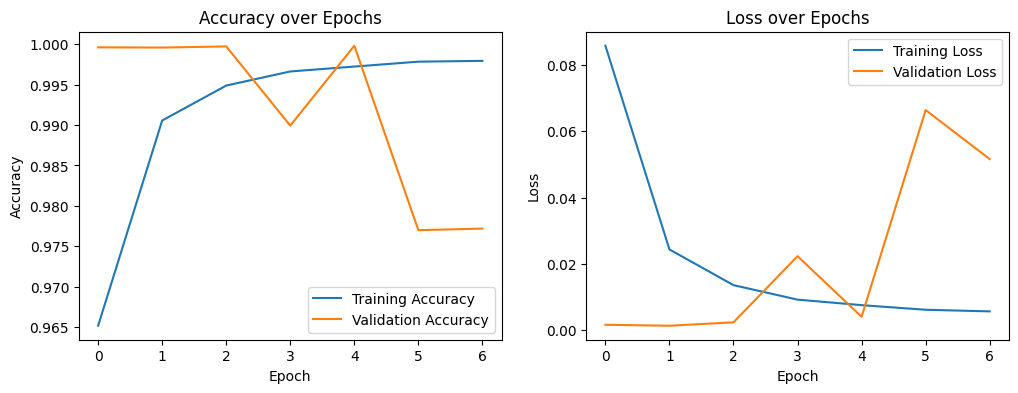

In [1]:
# Step 1: Import required libraries
import os
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Step 2: Helper function to find files matching specific patterns in the directory
def find_file(patterns):
    for file in os.listdir():
        for pattern in patterns:
            if pattern.lower() in file.lower():
                return file
    return None

# Expected patterns for training and testing files
training_patterns = ["training", "unsw_nb15_training"]
testing_patterns  = ["testing", "unsw_nb15_testing"]
training_filename = find_file(training_patterns)
testing_filename  = find_file(testing_patterns)

# If both files are found in the directory, use them; otherwise, upload the files
if training_filename and testing_filename:
    print("Files available in the directory:")
    print("Training file:", training_filename)
    print("Testing file:", testing_filename)
else:
    from google.colab import files
    uploaded = files.upload()  # Upload the training and testing files
    keys = list(uploaded.keys())
    print("Uploaded files:", keys)
    if not training_filename:
        training_filename = [k for k in keys if "training" in k.lower()][0]
    if not testing_filename:
        testing_filename = [k for k in keys if "testing" in k.lower()][0]

# Step 3: Read the files
# If the file exists in the directory, read it directly; otherwise, use the in-memory data
if os.path.exists(training_filename):
    train_df = pd.read_csv(training_filename)
else:
    train_df = pd.read_csv(io.BytesIO(uploaded[training_filename]))
if os.path.exists(testing_filename):
    test_df = pd.read_csv(testing_filename)
else:
    test_df = pd.read_csv(io.BytesIO(uploaded[testing_filename]))
print("Training DataFrame shape:", train_df.shape)
print("Testing DataFrame shape:", test_df.shape)

# Step 4: Labeling
# If the 'label' column does not exist, use the 'attack_cat' column to create it:
if 'label' not in train_df.columns:
    train_df['label'] = train_df['attack_cat'].apply(lambda x: 0 if x == 'Normal' else 1)
if 'label' not in test_df.columns:
    test_df['label'] = test_df['attack_cat'].apply(lambda x: 0 if x == 'Normal' else 1)

# Step 5: Separate features (X) and labels (y)
X_train = train_df.drop(['label'], axis=1)
y_train = train_df['label']
X_test = test_df.drop(['label'], axis=1)
y_test = test_df['label']

# Step 6: Process categorical features
# We assume that the columns 'proto', 'service', and 'state' are nominal.
nominal_cols = ['proto', 'service', 'state']
existing_nominal_cols = [col for col in nominal_cols if col in X_train.columns]

if existing_nominal_cols:
    # Use sparse_output instead of sparse
    ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    # Process the training data
    train_encoded = ohe.fit_transform(X_train[existing_nominal_cols])
    encoded_feature_names = ohe.get_feature_names_out(existing_nominal_cols)
    train_encoded_df = pd.DataFrame(train_encoded, columns=encoded_feature_names, index=X_train.index)
    X_train.drop(existing_nominal_cols, axis=1, inplace=True)
    X_train = pd.concat([X_train, train_encoded_df], axis=1)

    # Apply the same transformation on the testing data
    test_encoded = ohe.transform(X_test[existing_nominal_cols])
    test_encoded_df = pd.DataFrame(test_encoded, columns=encoded_feature_names, index=X_test.index)
    X_test.drop(existing_nominal_cols, axis=1, inplace=True)
    X_test = pd.concat([X_test, test_encoded_df], axis=1)

# Process any remaining textual features (if any) using LabelEncoder
remaining_categorical_train = X_train.select_dtypes(include=['object']).columns
for col in remaining_categorical_train:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col])
remaining_categorical_test = X_test.select_dtypes(include=['object']).columns
for col in remaining_categorical_test:
    le = LabelEncoder()
    X_test[col] = le.fit_transform(X_test[col])

# Step 7: Normalize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# Step 8: Reshape the data for use in an LSTM model
# LSTM models expect three-dimensional input: [samples, timesteps, features]
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_scaled  = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Step 9: Build the Bidirectional LSTM model
model = Sequential()
model.add(Bidirectional(LSTM(64, return_sequences=True, dropout=0.3, recurrent_dropout=0.3),
                        input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(32, dropout=0.3, recurrent_dropout=0.3)))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# Step 10: Define callbacks to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Step 11: Train the model
history = model.fit(X_train_scaled, y_train,
                    epochs=50,
                    batch_size=64,
                    validation_split=0.2,
                    callbacks=[early_stop, reduce_lr])

# Step 12: Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test_scaled, y_test)
print("Test loss:", loss)
print("Test accuracy:", accuracy)

# Step 13: Make predictions and print the classification report
y_pred = (model.predict(X_test_scaled) > 0.5).astype("int32")
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Step 14: Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Step 15: Plot accuracy and loss curves over the training epochs
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()